In [ ]:
# Install core libraries for data processing and machine learning
!pip install pandas numpy scikit-learn matplotlib tensorflow

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

# Load the dataset
data_path = '/content/drive/MyDrive/CICIDS2017_sample.csv'
df = pd.read_csv(data_path)
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   Flow Duration  Total Fwd Packets  Total Backward Packets  \
0              4                  2                       0   
1         142377                 46                      62   
2         118873                 23                      28   
3         143577                 43                      55   
4         143745                 49                      59   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                           37                            0   
1                         1325                       105855   
2                         1169                        45025   
3                         1301                       107289   
4                         1331                       110185   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                     31              

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Ensure TensorFlow 2.x is used
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.17.1


In [ ]:
df.dropna(inplace=True)

In [ ]:
df['Label'].value_counts()

,count
Label,
BENIGN,22728
DoS,18984
PortScan,7946
BruteForce,2767
WebAttack,2180
Bot,1966
Infiltration,36


<ipython-input-10-a6fb6cee3b63>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p=sns.distplot(a=df['Flow Duration'])


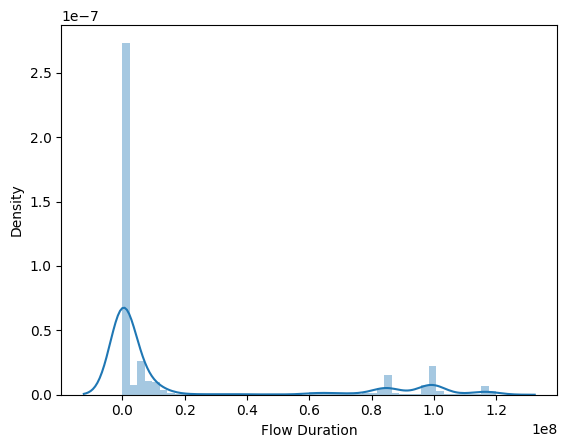

In [ ]:
import seaborn as sns
p=sns.distplot(a=df['Flow Duration'])
plt.show()

In [ ]:
df.shape

(56607, 78)

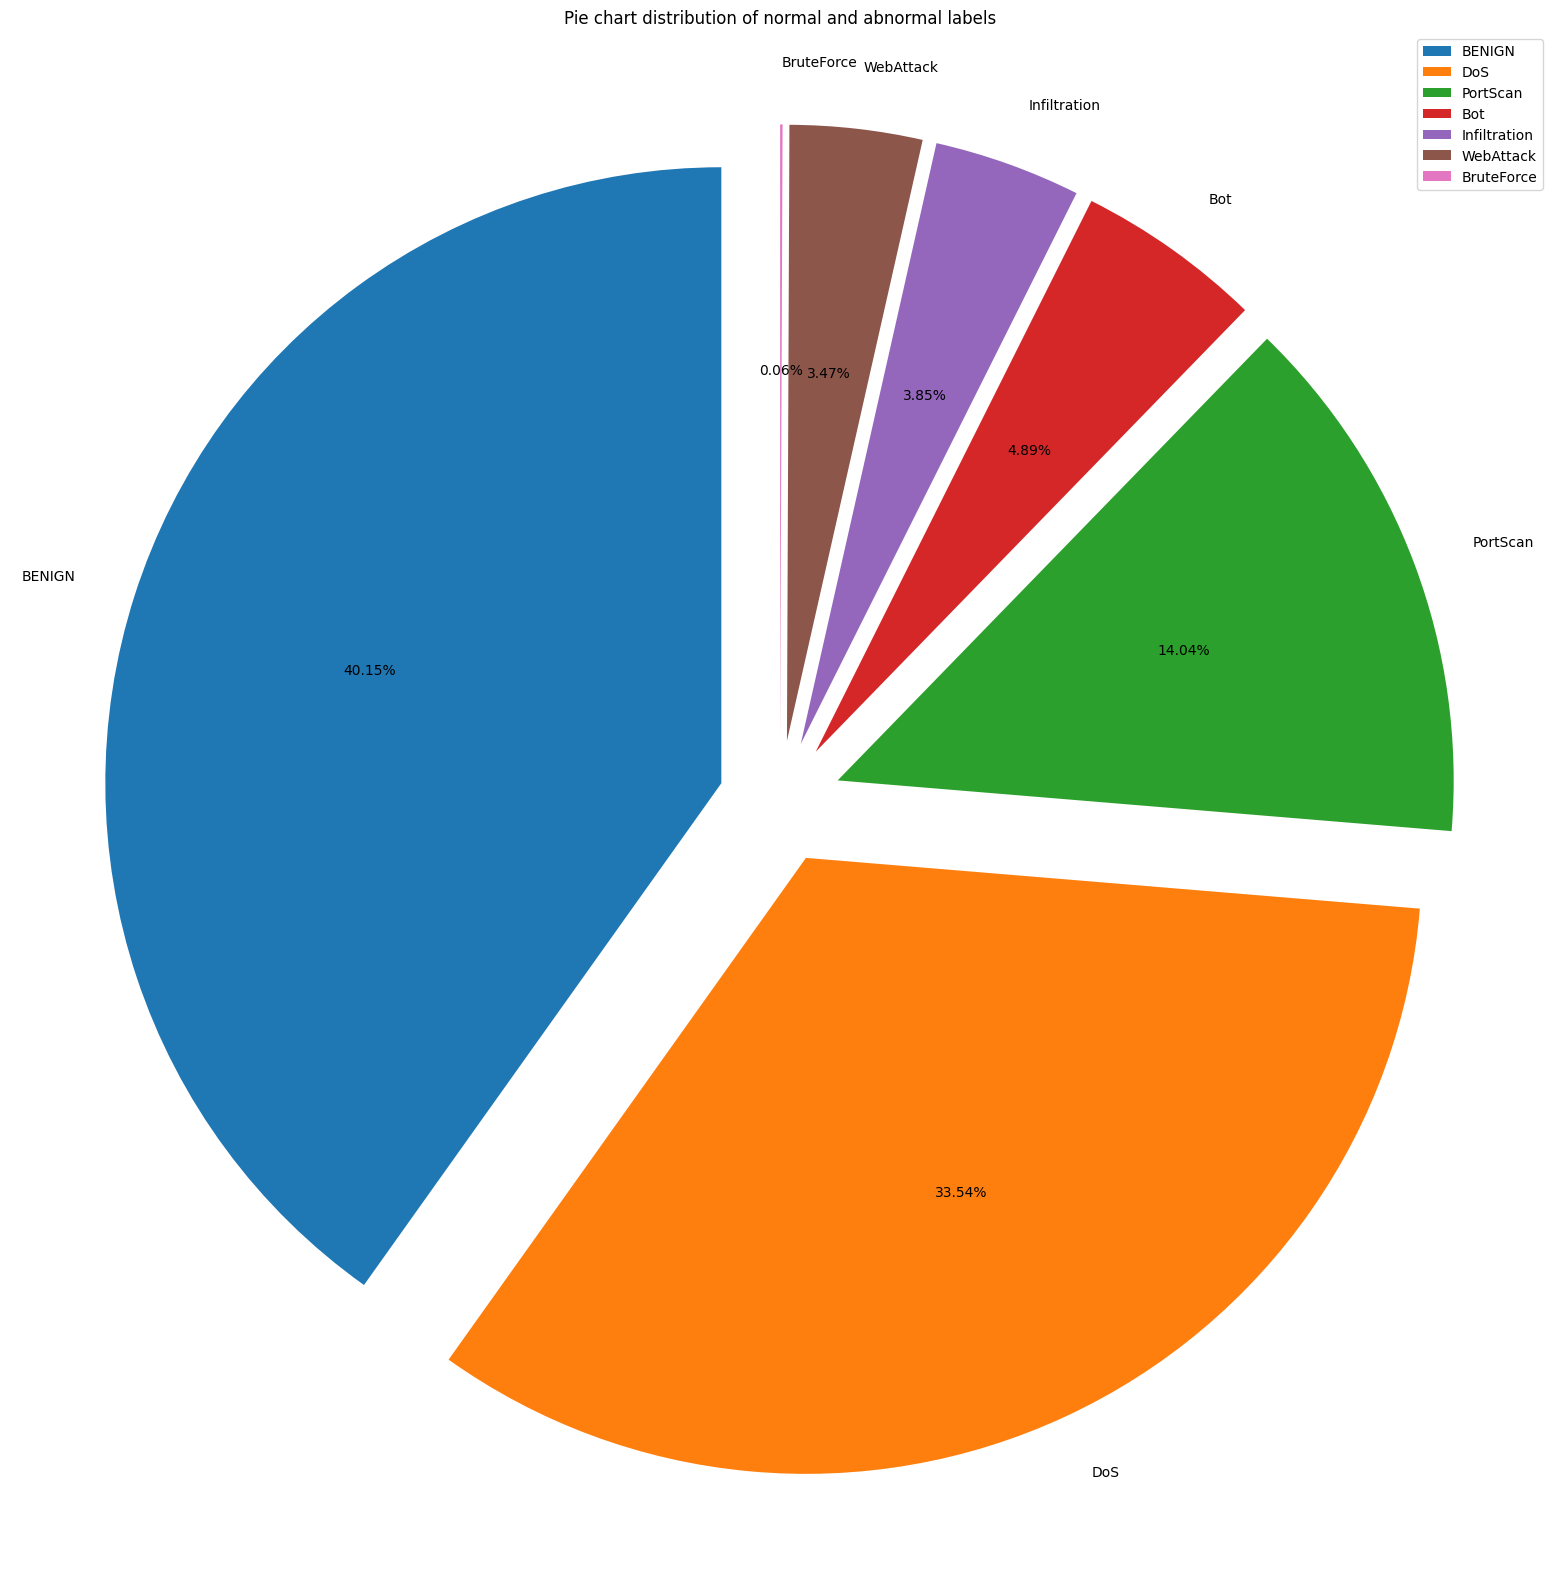

In [ ]:
import matplotlib.pyplot as plt

# Increase figure size
plt.figure(figsize=(20, 20))

# Pie chart distribution of normal and abnormal labels
labels = df['Label'].unique()
sizes = df['Label'].value_counts()
explode = (0.1,) * len(labels)  # Explode all slices slightly

plt.pie(sizes, labels=labels, autopct="%0.2f%%", explode=explode, startangle=90)

# Title and legend
plt.title("Pie chart distribution of normal and abnormal labels")
plt.legend(labels, loc="best")

plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Make a copy of your DataFrame
df_encoded = df.copy()

# Create a label (category) encoder object
le = LabelEncoder()

# Fit and transform the "Label" column, and assign the transformed values to a new column
df_encoded['Label'] = le.fit_transform(df['Label'])

# Print the mapping of original labels to encoded values
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:")
print(label_mapping)

# Display the modified DataFrame
print("\nEncoded DataFrame:")
print(df_encoded.head())

Label Mapping:
{'BENIGN': 0, 'Bot': 1, 'BruteForce': 2, 'DoS': 3, 'Infiltration': 4, 'PortScan': 5, 'WebAttack': 6}

Encoded DataFrame:
   Flow Duration  Total Fwd Packets  Total Backward Packets  \
0              4                  2                       0   
1         142377                 46                      62   
2         118873                 23                      28   
3         143577                 43                      55   
4         143745                 49                      59   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                           37                            0   
1                         1325                       105855   
2                         1169                        45025   
3                         1301                       107289   
4                         1331                       110185   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                     31       

In [ ]:
import joblib
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Save the LabelEncoder object to a file in Google Drive
encoder_file_path = '/content/drive/My Drive/label_encoder.pkl'
joblib.dump(le, encoder_file_path)

print(f"Label encoder saved to: {encoder_file_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Label encoder saved to: /content/drive/My Drive/label_encoder.pkl


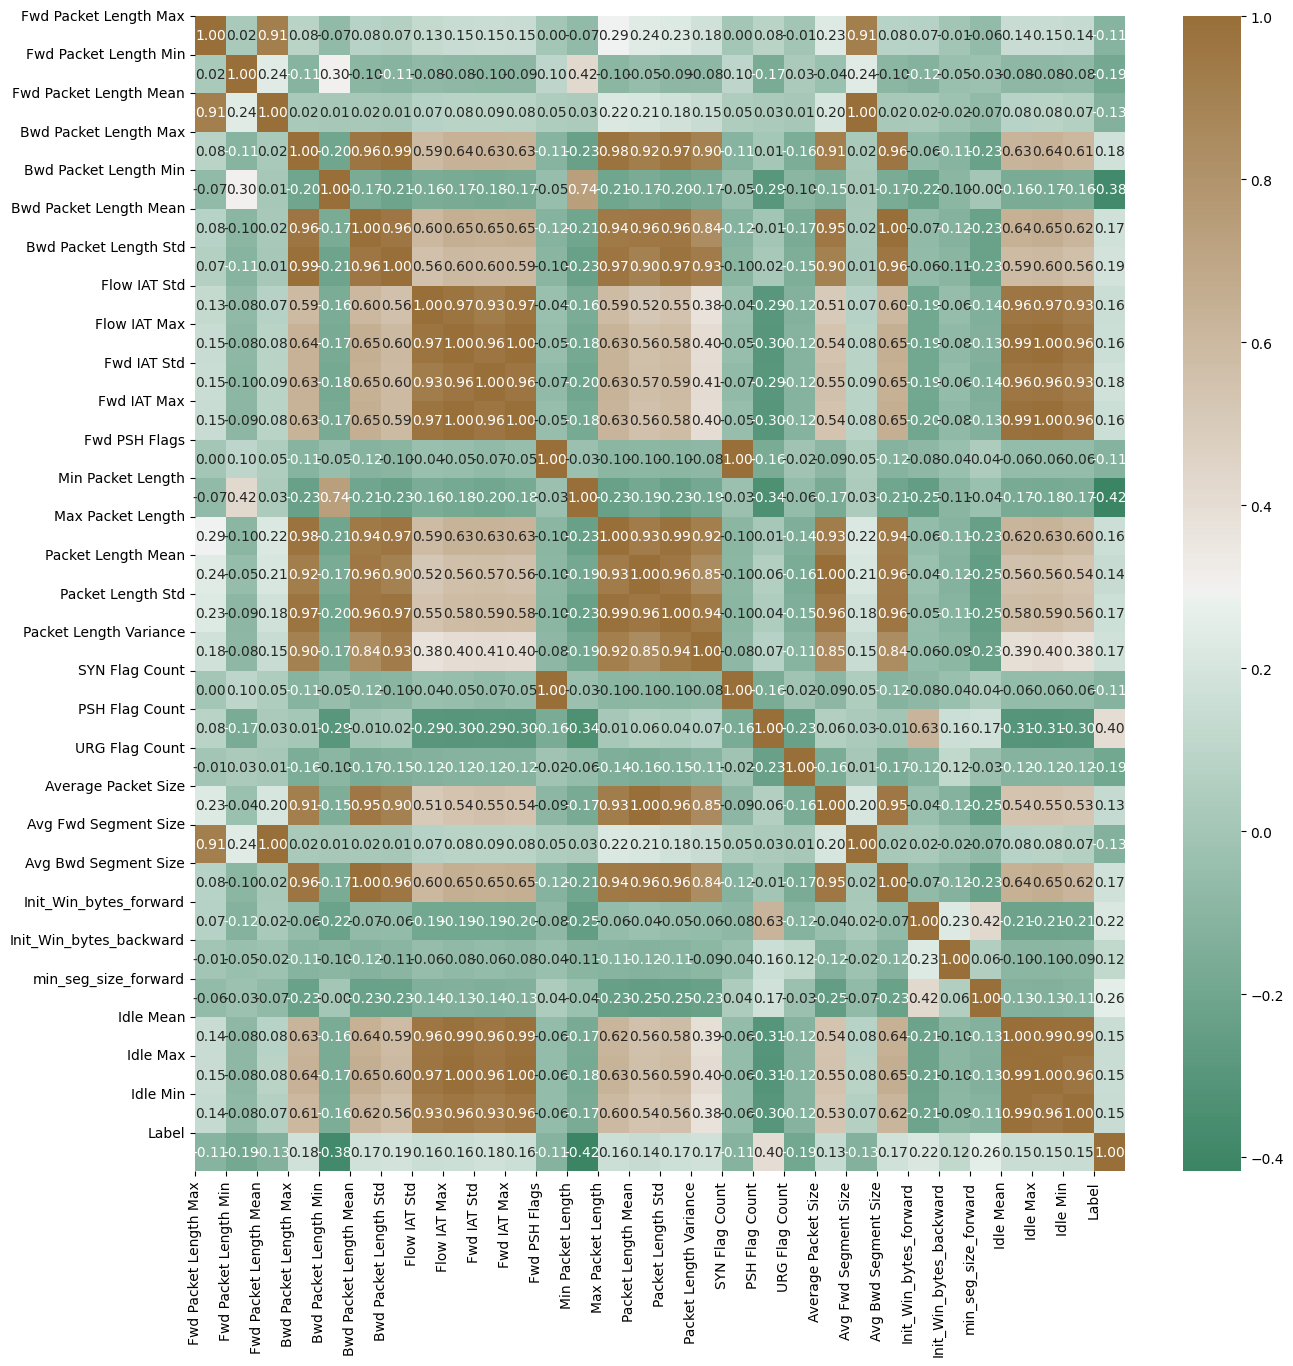

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the correlation threshold
correlation_threshold = 0.1  # You can adjust this threshold as needed

# Calculate the correlation matrix
corr = df_encoded.corr()

# Filter columns based on correlation threshold
columns_to_include = corr.columns[abs(corr['Label']) >= correlation_threshold]
filtered_corr = corr.loc[columns_to_include, columns_to_include]

# Plot the filtered correlation heatmap
fig, ax = plt.subplots(figsize=(15, 15))
colormap = sns.diverging_palette(150, 50, as_cmap=True)
sns.heatmap(filtered_corr, cmap=colormap, annot=True, fmt=".2f")

plt.xticks(range(len(filtered_corr.columns)), filtered_corr.columns, rotation=90)
plt.yticks(range(len(filtered_corr.columns)), filtered_corr.columns)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
import pandas as pd

# Replace infinite values with a large finite value
df_encoded = df_encoded.replace([float('inf'), -float('inf')], 0)

# Separate features and labels
X = df_encoded.drop(['Label'], axis=1)
y = df_encoded['Label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_classifier.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame with feature names and their importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top 20 features
top_features = feature_importance_df.head(20)['Feature'].tolist()

# Filter your original DataFrame to include only the top 20 features
df_top_features = df_encoded[top_features + ['Label']]

# Display the DataFrame with top features
df_top_features.head()

,Bwd Packet Length Std,Init_Win_bytes_forward,Average Packet Size,Packet Length Mean,Packet Length Variance,Bwd Packet Length Mean,Packet Length Std,Bwd Packets/s,Bwd Packet Length Max,Subflow Bwd Bytes,...,Avg Bwd Segment Size,Fwd Header Length.1,Max Packet Length,Fwd Packet Length Mean,Total Length of Fwd Packets,Bwd Header Length,Fwd Header Length,Total Length of Bwd Packets,Avg Fwd Segment Size,Label
0,0.000000,60,34.000000,22.666667,2.083333e+02,0.000000,14.433757,0.000000,0,0,...,0.000000,40,31,18.500000,37,0,40,0,18.500000,0
1,846.172655,29200,992.407407,983.302752,1.107529e+06,1707.338710,1052.392050,435.463593,4344,105855,...,1707.338710,1168,4344,28.804348,1325,1992,1168,105855,28.804348,0
2,902.027366,29200,905.764706,888.346154,1.057450e+06,1608.035714,1028.323762,235.545498,2896,45025,...,1608.035714,744,2896,50.826087,1169,904,744,45025,50.826087,0
3,928.230389,29200,1108.061224,1096.868687,1.401064e+06,1950.709091,1183.665309,383.069712,4344,107289,...,1950.709091,1120,4344,30.255814,1301,1768,1120,107289,30.255814,0
4,928.861935,29200,1032.555556,1023.082569,1.317808e+06,1867.542373,1147.958350,410.449059,4344,110185,...,1867.542373,1252,4344,27.163265,1331,1896,1252,110185,27.163265,0


In [ ]:
df_top_features.columns

Index(['Bwd Packet Length Std', 'Init_Win_bytes_forward',
       'Average Packet Size', 'Packet Length Mean', 'Packet Length Variance',
       'Bwd Packet Length Mean', 'Packet Length Std', 'Bwd Packets/s',
       'Bwd Packet Length Max', 'Subflow Bwd Bytes', 'Init_Win_bytes_backward',
       'Avg Bwd Segment Size', 'Fwd Header Length.1', 'Max Packet Length',
       'Fwd Packet Length Mean', 'Total Length of Fwd Packets',
       'Bwd Header Length', 'Fwd Header Length', 'Total Length of Bwd Packets',
       'Avg Fwd Segment Size', 'Label'],
      dtype='object')

In [ ]:
# Assuming 'Label' is the target variable
X_top_features = df_top_features.drop(['Label'], axis=1)
y_top_features = df_top_features['Label']

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_top_features, y_top_features, test_size=0.2, random_state=42
)

# Checking the training dataset information
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45285 entries, 604 to 56476
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Bwd Packet Length Std        45285 non-null  float64
 1   Init_Win_bytes_forward       45285 non-null  int64  
 2   Average Packet Size          45285 non-null  float64
 3   Packet Length Mean           45285 non-null  float64
 4   Packet Length Variance       45285 non-null  float64
 5   Bwd Packet Length Mean       45285 non-null  float64
 6   Packet Length Std            45285 non-null  float64
 7   Bwd Packets/s                45285 non-null  float64
 8   Bwd Packet Length Max        45285 non-null  int64  
 9   Subflow Bwd Bytes            45285 non-null  int64  
 10  Init_Win_bytes_backward      45285 non-null  int64  
 11  Avg Bwd Segment Size         45285 non-null  float64
 12  Fwd Header Length.1          45285 non-null  int64  
 13  Max Packet Length  

In [ ]:
from sklearn import metrics
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Define a function to compute and display various accuracy metrics
def print_all_accuracy_matrix(algorithm, name):
    # Predicting the target value from the model for the samples
    y_train_log = algorithm.predict(X_train)
    y_test_log = algorithm.predict(X_test)

    # Accuracy
    acc_train_log = metrics.accuracy_score(y_train, y_train_log)
    acc_test_log = metrics.accuracy_score(y_test, y_test_log)
    print(name, ": Accuracy on training Data: {:.3f}".format(acc_train_log))
    print(name, ": Accuracy on test Data: {:.3f}".format(acc_test_log))
    print()

    # F1 Score
    f1_score_train_log = metrics.f1_score(y_train, y_train_log, average="macro")
    f1_score_test_log = metrics.f1_score(y_test, y_test_log, average="macro")
    print(name, ": F1_score on training Data: {:.3f}".format(f1_score_train_log))
    print(name, ": F1_score on test Data: {:.3f}".format(f1_score_test_log))
    print()

    # Recall
    recall_score_train_log = metrics.recall_score(y_train, y_train_log, average="macro")
    recall_score_test_log = metrics.recall_score(y_test, y_test_log, average="macro")
    print(name, ": Recall on training Data: {:.3f}".format(recall_score_train_log))
    print(name, ": Recall on test Data: {:.3f}".format(recall_score_test_log))
    print()

    # Precision
    precision_score_train_log = metrics.precision_score(y_train, y_train_log, average="macro")
    precision_score_test_log = metrics.precision_score(y_test, y_test_log, average="macro")
    print(name, ": Precision on training Data: {:.3f}".format(precision_score_train_log))
    print(name, ": Precision on test Data: {:.3f}".format(precision_score_test_log))

    # Classification Report
    print("\nClassification Report\n")
    print(metrics.classification_report(y_test, y_test_log))
    print("\n")

Supervised learning model

Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import joblib

# Initialize the Decision Tree Classifier
clf_dt = DecisionTreeClassifier(criterion="entropy", max_depth=4)

# Train the model
clf_dt.fit(X_train, y_train)

# Evaluate using a predefined accuracy metric function
print_all_accuracy_matrix(clf_dt, "DecisionTreeClassifier")

# Save the model
joblib.dump(clf_dt, 'DecisionTreeClassifier.joblib')


DecisionTreeClassifier : Accuracy on training Data: 0.839
DecisionTreeClassifier : Accuracy on test Data: 0.842

DecisionTreeClassifier : F1_score on training Data: 0.477
DecisionTreeClassifier : F1_score on test Data: 0.480

DecisionTreeClassifier : Recall on training Data: 0.529
DecisionTreeClassifier : Recall on test Data: 0.529

DecisionTreeClassifier : Precision on training Data: 0.449
DecisionTreeClassifier : Precision on test Data: 0.452

Classification Report

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      4437
           1       0.00      0.00      0.00       405
           2       0.00      0.00      0.00       531
           3       0.92      0.98      0.95      3911
           4       0.00      0.00      0.00         7
           5       1.00      0.99      0.99      1580
           6       0.46      0.89      0.60       451

    accuracy                           0.84     11322
   macro avg       0.45      0.53      

['DecisionTreeClassifier.joblib']

Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import joblib

# Initialize the Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)

# Train the model
rf_clf.fit(X_train, y_train)

# Evaluate using a predefined accuracy metric function
print_all_accuracy_matrix(rf_clf, "RandomForestClassifier")

# Save the model
joblib.dump(rf_clf, 'RandomForestClassifier.joblib')

RandomForestClassifier : Accuracy on training Data: 0.999
RandomForestClassifier : Accuracy on test Data: 0.996

RandomForestClassifier : F1_score on training Data: 0.994
RandomForestClassifier : F1_score on test Data: 0.983

RandomForestClassifier : Recall on training Data: 0.990
RandomForestClassifier : Recall on test Data: 0.972

RandomForestClassifier : Precision on training Data: 0.999
RandomForestClassifier : Precision on test Data: 0.996

Classification Report

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4437
           1       0.99      1.00      0.99       405
           2       1.00      1.00      1.00       531
           3       1.00      1.00      1.00      3911
           4       1.00      0.86      0.92         7
           5       1.00      1.00      1.00      1580
           6       0.99      0.96      0.97       451

    accuracy                           1.00     11322
   macro avg       1.00      0.97      

['RandomForestClassifier.joblib']

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
import joblib

# Initialize the Logistic Regression model
logreg_model = LogisticRegression()

# Train the model
logreg_model.fit(X_train, y_train)

# Evaluate using a predefined accuracy metric function
print_all_accuracy_matrix(logreg_model, "LogisticRegression")

# Save the model
joblib.dump(logreg_model, 'LogisticRegression.joblib')

LogisticRegression : Accuracy on training Data: 0.682
LogisticRegression : Accuracy on test Data: 0.680

LogisticRegression : F1_score on training Data: 0.474
LogisticRegression : F1_score on test Data: 0.485

LogisticRegression : Recall on training Data: 0.524
LogisticRegression : Recall on test Data: 0.551

LogisticRegression : Precision on training Data: 0.556
LogisticRegression : Precision on test Data: 0.546

Classification Report

              precision    recall  f1-score   support

           0       0.87      0.69      0.77      4437
           1       0.44      0.01      0.02       405
           2       0.09      0.41      0.15       531
           3       0.96      0.63      0.76      3911
           4       0.08      0.29      0.12         7
           5       0.71      0.99      0.82      1580
           6       0.67      0.84      0.74       451

    accuracy                           0.68     11322
   macro avg       0.55      0.55      0.48     11322
weighted avg     

['LogisticRegression.joblib']

XGBoost model

In [ ]:
import xgboost as xgb
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize and train the XGBoost Classifier
xg = xgb.XGBClassifier(n_estimators=10, random_state=42)
xg.fit(X_train, y_train)

# Evaluate the model
xg_score = xg.score(X_test, y_test)
y_predict = xg.predict(X_test)
y_true = y_test

# Print evaluation metrics
print('Accuracy of XGBoost: ' + str(xg_score))

precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))

# Print detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_predict))

Accuracy of XGBoost: 0.9930224341989048
Precision of XGBoost: 0.9930400954650008
Recall of XGBoost: 0.9930224341989048
F1-score of XGBoost: 0.9930209843872703

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4437
           1       0.99      0.99      0.99       405
           2       1.00      0.98      0.99       531
           3       1.00      0.99      0.99      3911
           4       1.00      0.86      0.92         7
           5       1.00      1.00      1.00      1580
           6       0.98      0.99      0.98       451

    accuracy                           0.99     11322
   macro avg       0.99      0.97      0.98     11322
weighted avg       0.99      0.99      0.99     11322



Stacking all the model , with meta model as rondam forest

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Train Base Models
dt_model = DecisionTreeClassifier(criterion="entropy", max_depth=4).fit(X_train, y_train)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)
logreg_model = LogisticRegression().fit(X_train, y_train)
xgb_model = xgb.XGBClassifier(n_estimators=10, random_state=42).fit(X_train, y_train)

# Predict Train and Test Data for Base Models
dt_train = dt_model.predict(X_train).reshape(-1, 1)
rf_train = rf_model.predict(X_train).reshape(-1, 1)
logreg_train = logreg_model.predict(X_train).reshape(-1, 1)
xg_train = xgb_model.predict(X_train).reshape(-1, 1)

dt_test = dt_model.predict(X_test).reshape(-1, 1)
rf_test = rf_model.predict(X_test).reshape(-1, 1)
logreg_test = logreg_model.predict(X_test).reshape(-1, 1)
xg_test = xgb_model.predict(X_test).reshape(-1, 1)

# Combine Base Model Predictions into New Features
x_train_stack = np.concatenate((dt_train, rf_train, logreg_train, xg_train), axis=1)
x_test_stack = np.concatenate((dt_test, rf_test, logreg_test, xg_test), axis=1)

# Train Meta-Model (Random Forest Classifier) on Stacked Features
meta_model = RandomForestClassifier(n_estimators=100, random_state=42).fit(x_train_stack, y_train)

# Make Predictions Using the Meta-Model
y_predict = meta_model.predict(x_test_stack)
y_true = y_test

# Evaluate Meta-Model
stk_score = accuracy_score(y_true, y_predict)
print('Accuracy of Stacking: ' + str(stk_score))

precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of Stacking: ' + str(precision))
print('Recall of Stacking: ' + str(recall))
print('F1-score of Stacking: ' + str(fscore))

print("\nClassification Report:\n")
print(classification_report(y_true, y_predict))

Accuracy of Stacking: 0.9955838191132309
Precision of Stacking: 0.9955753698945375
Recall of Stacking: 0.9955838191132309
F1-score of Stacking: 0.9955683913122665

Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4437
           1       0.99      1.00      0.99       405
           2       1.00      1.00      1.00       531
           3       1.00      1.00      1.00      3911
           4       1.00      0.86      0.92         7
           5       1.00      1.00      1.00      1580
           6       0.99      0.96      0.97       451

    accuracy                           1.00     11322
   macro avg       1.00      0.97      0.98     11322
weighted avg       1.00      1.00      1.00     11322



In [ ]:
import joblib

# Save the stacking ensemble model to a file
joblib.dump(meta_model, '/content/StackingEnsemble.joblib')

print("Model saved as StackingEnsemble.joblib")

Model saved as StackingEnsemble.joblib


unsupervised learning

In [ ]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a preprocessing pipeline
from sklearn.pipeline import Pipeline
import joblib

pipeline = Pipeline([
    ('scaler', scaler)
])

# Save the pipeline
joblib.dump(pipeline, "preprocess_pipeline_AE_39ft.save")
print("Preprocessing pipeline saved as preprocess_pipeline_AE_39ft.save")

Preprocessing pipeline saved as preprocess_pipeline_AE_39ft.save


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming 'Label' is the target variable
X_top_features = df_top_features.drop(['Label'], axis=1)
y_top_features = df_top_features['Label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_top_features, y_top_features, test_size=0.2, random_state=42
)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler
import joblib
joblib.dump(scaler, "scaler.pkl")
print("Scaler saved as scaler.pkl")

Scaler saved as scaler.pkl


isolation forest

In [ ]:
from sklearn.ensemble import IsolationForest
import numpy as np

# Initialize and fit the Isolation Forest model
iso_forest = IsolationForest(
    n_estimators=100,  # Number of base estimators
    contamination=0.05,  # Estimated proportion of anomalies in the data
    random_state=42
)
iso_forest.fit(X_train_scaled)

# Save the trained Isolation Forest model
import joblib
joblib.dump(iso_forest, "isolation_forest_model.pkl")
print("Isolation Forest model saved as isolation_forest_model.pkl")


Isolation Forest model saved as isolation_forest_model.pkl


In [ ]:
from sklearn.ensemble import IsolationForest
import numpy as np

# Initialize and fit the Isolation Forest model
iso_forest = IsolationForest(
    n_estimators=100,  # Number of base estimators
    contamination=0.05,  # Estimated proportion of anomalies in the data
    random_state=42
)
iso_forest.fit(X_train_scaled)

# Save the trained Isolation Forest model
import joblib
joblib.dump(iso_forest, "isolation_forest_model.pkl")
print("Isolation Forest model saved as isolation_forest_model.pkl")

Isolation Forest model saved as isolation_forest_model.pkl


In [ ]:
# Predict anomalies (-1: anomaly, 1: normal)
y_pred_test = iso_forest.predict(X_test_scaled)

# Convert predictions to binary (1 for anomalies, 0 for normal)
anomalies_test = (y_pred_test == -1)

# Print results
print(f"Number of Anomalies Detected in Test Data: {np.sum(anomalies_test)}")
print(f"Anomaly Proportion in Test Data: {np.mean(anomalies_test) * 100:.2f}%")

Number of Anomalies Detected in Test Data: 580
Anomaly Proportion in Test Data: 5.12%


Autoencoders

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Define the autoencoder structure
input_dim = X_train_scaled.shape[1]  # Number of input features
encoding_dim = 32  # Latent space size

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation="relu")(input_layer)
encoded = Dense(encoding_dim, activation="relu")(encoded)

# Decoder
decoded = Dense(64, activation="relu")(encoded)
decoded = Dense(input_dim, activation="sigmoid")(decoded)

# Autoencoder Model
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

# Train the Autoencoder
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,  # Training to reconstruct input
    epochs=50,
    batch_size=32,
    validation_data=(X_test_scaled, X_test_scaled),
    verbose=1
)

# Save the trained autoencoder model
autoencoder.save("autoencoder_39ft.hdf5")
print("Autoencoder model saved as autoencoder_39ft.hdf5")

Epoch 1/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.8324 - val_loss: 0.9199
Epoch 2/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.4835 - val_loss: 0.9194
Epoch 3/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5694 - val_loss: 0.9194
Epoch 4/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.0835 - val_loss: 0.9190
Epoch 5/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.5723 - val_loss: 0.9188
Epoch 6/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.5518 - val_loss: 0.9187
Epoch 7/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5322 - val_loss: 0.9188
Epoch 8/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5038 - val_loss: 0.9188
Epoch 9/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0253 - val_loss: 0.9187
Epoch 10/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.5615 - val_loss: 0.9186
Epoch 11/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.5545 - val_loss: 0.9186
Epoch 12/50
1416/1416 ━━━━━━━━

Autoencoder model saved as autoencoder_39ft.hdf5


In [ ]:
# Predict the reconstructed data
X_test_reconstructed = autoencoder.predict(X_test_scaled)

# Compute reconstruction errors
reconstruction_errors = np.mean(np.square(X_test_scaled - X_test_reconstructed), axis=1)

# Set a threshold for anomaly detection
threshold = np.percentile(reconstruction_errors, 95)  # Top 5% as anomalies

# Identify anomalies
anomalies = reconstruction_errors > threshold

# Print results
print(f"Reconstruction Error Threshold: {threshold}")
print(f"Number of Anomalies Detected: {np.sum(anomalies)}")
print(f"Anomaly Proportion in Test Data: {np.mean(anomalies) * 100:.2f}%")

354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Reconstruction Error Threshold: 1.0700966571831825
Number of Anomalies Detected: 567
Anomaly Proportion in Test Data: 5.01%
